In [1]:
import math
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [142]:
data = pd.DataFrame()

data["strikes"] = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
data["prices"] = [10.93, 9.55, 8.28, 7.4, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]

In [4]:
r = 0
t = 0
S = 100
sigma = 0.2
T=1

def calculate_d1_d2(data, r, sigma):
    data['d1'] = (np.log(S / data["strikes"]) + (r + (sigma**2) / 2) * 1) / (sigma * np.sqrt(1))
    data['d2'] = data['d1'] - sigma * np.sqrt(1)
    
def calculate_call_price(data, r):
    data['black_scholes_price'] = S * norm.cdf(data['d1']) - data["strikes"] * np.exp(-r * 1) * norm.cdf(data['d2'])  
    
calculate_d1_d2(data, r, sigma)
calculate_call_price(data, r) #Estimation Black Scholes

In [165]:
import scipy.stats as ss
from decimal import Decimal
import math as m
import numpy as np
from datetime import date,timedelta

def call_bsm (S0,K,r,T,Otype,sig):
    d1 = (m.log(S0/K)) + (r+ (sig*sig)/2)*T/(sig*(m.sqrt(T)))
    d2 = d1 - sig*(m.sqrt(T))
    if (Otype == "Call"):
        price = S0*(ss.norm.cdf(np.float(d1))) \
        - K*(m.exp(-r*T))*(ss.norm.cdf(np.float(d2)))
        return (price)
    elif (Otype == "Put"):
        price  = -S0*(ss.norm.cdf(np.float(-d1)))\
        + K*(m.exp(-r*T))*(ss.norm.cdf(np.float(-d2)))
        return (price)

def vega (S0,K,r,T,sig):
    d1 = (m.log(S0/K))/(sig*(m.sqrt(T))) + ((r+ (sig*sig)/2)*T/(sig*(m.sqrt(T))))
    vega = S0*(ss.norm.pdf(np.float(d1)))*(m.sqrt(T))
    return(vega)
    
    
def imp_vol(S0, K, T, r, market,flag):
    e = 10e-15; x0 = (1);  
    def newtons_method(S0, K, T, r, market,flag,x0, e):
        delta = call_bsm (S0,K,r,T,flag,x0) - market
        while delta > e:
            x0 = (x0 - (call_bsm (S0,K,r,T,flag,x0) - market)/vega (S0,K,r,T,x0))
            delta = abs(call_bsm (S0,K,r,T,flag,x0) - market)
        return((x0))
    sig =  newtons_method(S0, K, T, r, market,flag,x0 , e)   
    return(sig)


In [166]:
data_test = data.copy()
data_test

,strikes,prices,implied_vol
0,95,10.93,0.210948
1,96,9.55,0.189023
2,97,8.28,0.170031
3,98,7.40,0.160956
4,99,6.86,0.160079
5,100,6.58,0.165124
6,101,6.52,0.175031
7,102,6.49,0.185098
8,103,6.47,0.194908
9,104,6.46,0.204530


In [167]:
iv = []

r = 0
t = 0
S = 
sigma = 0.2
T=8/12
flag = 'Call'

for i,j in zip(data_test['strikes'],data_test['prices']):
    iv.append(imp_vol(S,i,T,r,j,'Call'))
data_test["implied_vol"] = iv

C:\Users\user\AppData\Local\Temp\ipykernel_9388\2895319876.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  price = S0*(ss.norm.cdf(np.float(d1))) \
C:\Users\user\AppData\Local\Temp\ipykernel_9388\2895319876.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  - K*(m.exp(-r*T))*(ss.norm.cdf(np.float(d2)))
C:\Users\user\AppData\Local\T

In [169]:
data_test

,strikes,prices,implied_vol
0,95,10.93,0.214806
1,96,9.55,0.191908
2,97,8.28,0.171904
3,98,7.40,0.161847
4,99,6.86,0.160302
5,100,6.58,0.165124
6,101,6.52,0.175224
7,102,6.49,0.185800
8,103,6.47,0.196357
9,104,6.46,0.206900


In [177]:
def newton_raphson_implied_vol(row, S, r, T,initial_guess=0.2):     
    sigma = initial_guess     
    K = row['strikes']  # Prix d'exercice
    price_market = row['prices']  # Prix du marché
    for _ in range(100):           
        d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        price_model = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)  # Prix calculé par le modèle
        vega = S * np.sqrt(T) * norm.pdf(d1)  # Vega
        price_diff = price_market - price_model  # Différence de prix                  
        if np.abs(price_diff) < 1e-8:               
            return sigma                  
        sigma += price_diff / vega  # Mise à jour de sigma
        if sigma < 0:               
            sigma = 0.001     
    return sigma

# Application de la fonction au DataFrame
data["implied_vol"] = data.apply(lambda row: newton_raphson_implied_vol(row, S, r, 1), axis=1)
data["implied_vol"]

0    0.210948
1    0.189023
2    0.170031
3    0.160956
4    0.160079
5    0.165124
6    0.175031
7    0.185098
8    0.194908
9    0.204530
Name: implied_vol, dtype: float64

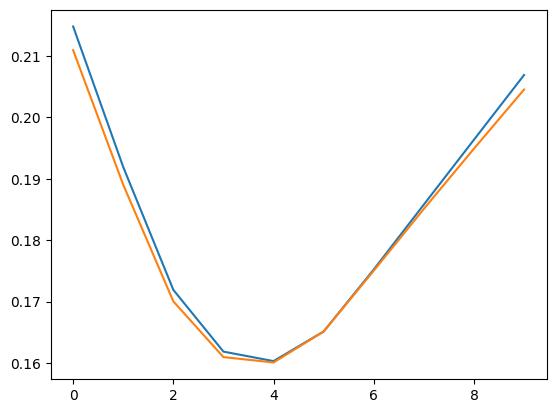

In [170]:
data_test['implied_vol'].plot()
data['implied_vol'].plot()

plt.show()

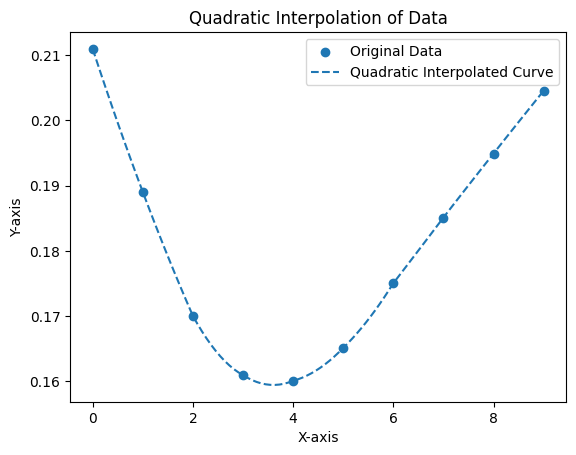

In [7]:
#quadratic interp for better smoothing of the curve

def quadratic_interpolation(x_interpolated, x_original, y_original):
    y_interpolated = []

    for x in x_interpolated:
        # Find the segment in which x falls
        for i in range(len(x_original) - 2):
            if x_original[i] <= x <= x_original[i + 2]:
                x1, x2, x3 = x_original[i], x_original[i + 1], x_original[i + 2]
                y1, y2, y3 = y_original[i], y_original[i + 1], y_original[i + 2]
                break

        # Quadratic interpolation formula
        # Solving for coefficients a, b, and c of the quadratic equation y = ax^2 + bx + c
        A = np.array([[x1**2, x1, 1], [x2**2, x2, 1], [x3**2, x3, 1]])
        B = np.array([y1, y2, y3])
        a, b, c = np.linalg.solve(A, B)

        # Calculate the interpolated y value
        y = a*x**2 + b*x + c
        y_interpolated.append(y)

    return y_interpolated

# Example data
# Replace 'data.index' and 'data["implied_vol"]' with your actual data
x_original = np.array(data.index)
y_original = np.array(data["implied_vol"])

nb_pts = 100
x_interpolated = np.linspace(x_original.min(), x_original.max(), nb_pts)
y_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

# Plotting
plt.scatter(x_original, y_original, label='Original Data')
plt.plot(x_interpolated, y_interpolated, label='Quadratic Interpolated Curve', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Quadratic Interpolation of Data')
plt.show()

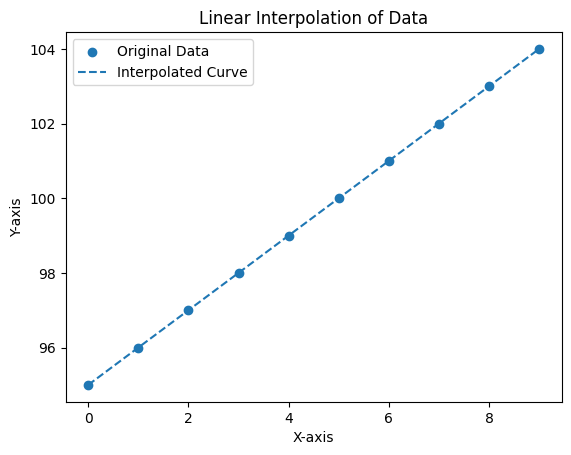

In [8]:
#interpolation of strikes

x_original=data.index
y_original=data["strikes"]
nb_pts=100
x_interpolated=np.linspace(x_original.min(), x_original.max(), nb_pts)
strike_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

plt.scatter(x_original, y_original, label='Original Data')
plt.plot(x_interpolated, strike_interpolated, label='Interpolated Curve', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Linear Interpolation of Data')
plt.show()

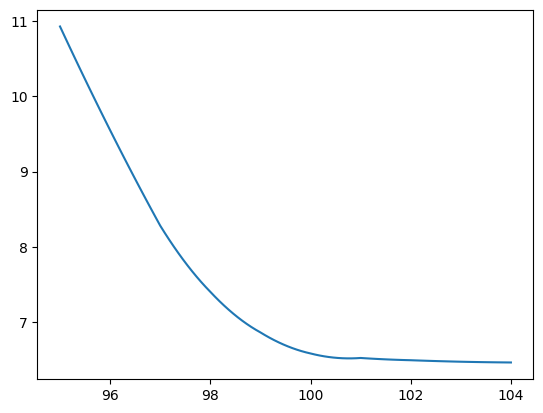

In [9]:
def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

prices=[]

for i,j in zip(strike_interpolated,y_interpolated):
    prices.append(black_scholes_call_price(S,i,T,r,j))

df=pd.DataFrame([prices,strike_interpolated],index=["Price","Strike"]).T
plt.plot(df["Strike"],df["Price"])


In [13]:
df['Strike']


0      95.000000
1      95.090909
2      95.181818
3      95.272727
4      95.363636
         ...    
95    103.636364
96    103.727273
97    103.818182
98    103.909091
99    104.000000
Name: Strike, Length: 100, dtype: float64

# II – Interpolation et volatilité locale 

3/ Déterminez la nappe de volatilité correspondant à ces 40 options. Proposer un prix, le plus juste 
possible, pour une option de strike 99.50 et de maturité 8 mois (justifier la méthode retenue).

In [255]:
data_12_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                'prices': [10.93, 9.55, 8.28, 7.40, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]}

df_12_months = pd.DataFrame(data_12_months)

data_9_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                 'prices':[11.79 ,8.95 ,8.07 ,7.03 ,6.18 ,6.04 ,5.76 ,5.50 ,5.50 ,5.39]}

df_9_months = pd.DataFrame(data_9_months)

data_6_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                    'prices': [10.71 ,8.28 ,6.91 ,6.36 ,5.29 ,5.07 ,4.76 ,4.47 ,4.35 ,4.14]}
df_6_months = pd.DataFrame(data_6_months)

data_3_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                 'prices': [8.67, 7.14, 5.98, 4.93, 4.09, 3.99, 3.43, 3.01, 2.72, 2.53]}

df_3_months = pd.DataFrame(data_3_months)


# On utilise l'algorithme de Newton Raphson pour trouver les volatilités implicites

df_12_months["implied_vol"] = df_12_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, 1), axis=1)
df_9_months["implied_vol"] = df_9_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, 9/12), axis=1)
df_6_months["implied_vol"] = df_6_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, 6/12), axis=1)
df_3_months["implied_vol"] = df_3_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, 3/12), axis=1)



In [256]:
df_6_months_10v = df_6_months.copy()
df_9_months_10v = df_9_months.copy()

On utilise la fonction d'interpolation quadratique, pour lisser la courbe

In [257]:
def interpolation(data):
    prices = []
    #interpolation of vol
    x_original = np.array(data.index)
    y_original = np.array(data["implied_vol"])

    nb_pts = 100
    x_interpolated = np.linspace(x_original.min(), x_original.max(), nb_pts)
    y_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

    #interpolation of strikes
    x_original=data.index
    y_original=data["strikes"]
    x_interpolated=np.linspace(x_original.min(), x_original.max(), nb_pts)
    strike_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

    #Calcul des prix avec la formule de black scholes en fonction des paramêtres interpolés
    for i,j in zip(strike_interpolated,y_interpolated):
        prices.append(black_scholes_call_price(S,i,T,r,j))
    df=pd.DataFrame([prices,strike_interpolated,y_interpolated],index=["prices","strikes",'implied_vol']).T
    return df

In [258]:
df_12_months = interpolation(df_12_months)
df_9_months = interpolation(df_9_months)
df_6_months = interpolation(df_6_months)
df_3_months = interpolation(df_3_months)

In [259]:
df_12_months['maturité'] =  [1]*100
df_9_months['maturité'] = [0.75]*100
df_6_months['maturité'] = [0.5]*100
df_3_months['maturité'] = [0.25]*100

# print("Options de maturité 9 mois:")
# print(df_9_months)

# print("\nOptions de maturité 6 mois:")
# print(df_6_months)

# print("\nOptions de maturité 3 mois:")
# print(df_3_months)

In [183]:
df_concatenated = pd.concat([df_12_months,df_9_months, df_6_months, df_3_months])

print(df_concatenated)

       prices     strikes  implied_vol  maturité
0   10.930000   95.000000     0.210948      1.00
1   10.800166   95.090909     0.208834      1.00
2   10.671194   95.181818     0.206743      1.00
3   10.543090   95.272727     0.204678      1.00
4   10.415857   95.363636     0.202636      1.00
..        ...         ...          ...       ...
95   6.608547  103.636364     0.204720      0.25
96   6.605483  103.727273     0.205535      0.25
97   6.603726  103.818182     0.206379      0.25
98   6.603274  103.909091     0.207253      0.25
99   6.604125  104.000000     0.208156      0.25

[400 rows x 4 columns]


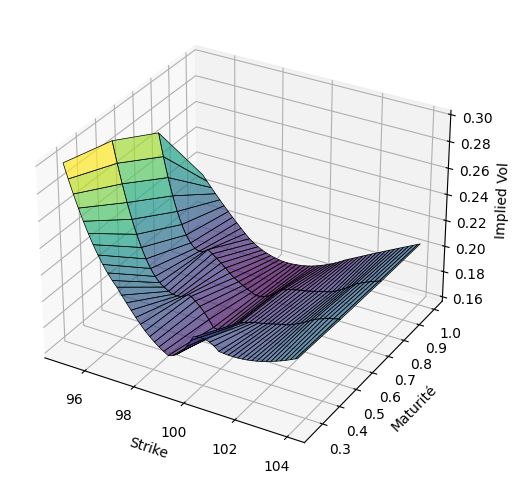

In [260]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Utilisation de plot_surface
ax.plot_surface(df_concatenated['strikes'].values.reshape(4, -1),
                df_concatenated['maturité'].values.reshape(4, -1),
                df_concatenated['implied_vol'].values.reshape(4, -1),
                cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.7)

# Configurations supplémentaires
ax.set_xlabel('Strike')
ax.set_ylabel('Maturité')
ax.set_zlabel('Implied Vol')

plt.show()

In [261]:
df_concatenated


,prices,strikes,implied_vol,maturité
0,10.930000,95.000000,0.210948,1.00
1,10.800166,95.090909,0.208834,1.00
2,10.671194,95.181818,0.206743,1.00
3,10.543090,95.272727,0.204678,1.00
4,10.415857,95.363636,0.202636,1.00
...,...,...,...,...
95,6.608547,103.636364,0.204720,0.25
96,6.605483,103.727273,0.205535,0.25
97,6.603726,103.818182,0.206379,0.25
98,6.603274,103.909091,0.207253,0.25


In [203]:
iv = []
estim = black_scholes_call_price(100,99.5,8/12,0,0.2)
estim

data_estim = {'strikes': [99.5],
                'prices': [estim]}
df_estim = pd.DataFrame(data_estim)

r = 0
t = 0
S = 100
sigma = 0.2
T=8/12
flag = 'Call'

for i,j in zip(df_estim['strikes'],df_estim['prices']):
    iv.append(imp_vol(S,i,T,r,j,'Call'))
df_estim["implied_vol"] = iv

C:\Users\user\AppData\Local\Temp\ipykernel_9388\2895319876.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  price = S0*(ss.norm.cdf(np.float(d1))) \
C:\Users\user\AppData\Local\Temp\ipykernel_9388\2895319876.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  - K*(m.exp(-r*T))*(ss.norm.cdf(np.float(d2)))
C:\Users\user\AppData\Local\T

In [204]:
df_estim

,strikes,prices,implied_vol
0,99.5,6.744251,0.200066


In [205]:
from scipy.optimize import fsolve
from scipy.stats import norm
import numpy as np

# Fonction pour le modèle Black-Scholes
def black_scholes(volatility, S, K, T, r, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * volatility**2) * T) / (volatility * np.sqrt(T))
    d2 = d1 - volatility * np.sqrt(T)
    
    if option_type == 'call':
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option_type. Use 'call' or 'put'.")
    
    return option_price

# Fonction pour trouver la volatilité implicite
def find_implied_volatility(volatility_guess, *args):
    S, K, T, r, option_price, option_type = args
    return black_scholes(volatility_guess, S, K, T, r, option_type) - option_price

# Paramètres de l'option
S = 100  # Prix actuel du sous-jacent
K = 99.50  # Strike de l'option
T = 8 / 12  # Maturité en années (8 mois)
r = 0  # Taux d'intérêt sans risque

# Prix observé de l'option sur le marché
market_option_price = 6.744251  # Remplacez par le prix observé sur le marché

# Guess initial pour la volatilité implicite
initial_volatility_guess = 0.2

# Utilisation de fsolve pour trouver la volatilité implicite
implied_volatility = fsolve(find_implied_volatility, initial_volatility_guess,
                            args=(S, K, T, r, market_option_price, 'call'))[0]

print(f"Volatilité implicite : {implied_volatility:.4f}")


Volatilité implicite : 0.2000


In [273]:
strike_prices_9_months = df_concatenated[df_concatenated['maturité']==0.75]['strikes']
print(strike_prices_9_months)

0      95.000000
1      95.090909
2      95.181818
3      95.272727
4      95.363636
         ...    
95    103.636364
96    103.727273
97    103.818182
98    103.909091
99    104.000000
Name: strikes, Length: 100, dtype: float64


In [275]:
list(df_concatenated[df_concatenated['maturité']==0.75]['implied_vol'].values)

[0.2699733162065867,
 0.2611338284875864,
 0.2527901582678827,
 0.24494230554747573,
 0.23759027032636543,
 0.23073405260455185,
 0.22437365238203497,
 0.21850906965881475,
 0.21314030443489124,
 0.20826735671026442,
 0.20389022648493427,
 0.20000891375890084,
 0.19662341853216408,
 0.19373374080472403,
 0.19133988057658066,
 0.189441837847734,
 0.188039612618184,
 0.1871332048879307,
 0.18672261465697412,
 0.1868078419253142,
 0.18738888669295095,
 0.18846574895988447,
 0.19003842872611462,
 0.18887644679326526,
 0.18767186915998324,
 0.1864246958262685,
 0.1851349267921211,
 0.18380256205754103,
 0.18242760162252827,
 0.18101004548708283,
 0.17954989365120472,
 0.17804714611489394,
 0.17650180287815048,
 0.17491386394097433,
 0.17379537721796626,
 0.17271963611362562,
 0.1716866406279524,
 0.17069639076094667,
 0.1697488865126084,
 0.16884412788293754,
 0.16798211487193415,
 0.16716284747959817,
 0.16638632570592968,
 0.16565254955092862,
 0.164961519014595,
 0.1650475138483373,
 0.1

In [276]:
def bilinear_interpolation(x, y, points):

# Formule t r o u v e sur https ://fr.wikipedia.org/wiki/Interpolation_bilin%C3%A9aire
    points = sorted(points)
    (x1 , y1 , q11), (_x1 , y2, q12), (x2, _y1 , q21), (_x2 , _y2 , q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError("points do not form a rectangle")
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError("(x, y) not within the rectangle ")

    return (q11 * (x2 - x) * (y2 - y) +
    q21 * (x - x1) * (y2 - y) +
    q12 * (x2 - x) * (y - y1) +
    q22 * (x - x1) * (y - y1)) / ((x2 - x1) * (y2 - y1) + 0.0)


In [277]:
x_val = 99
y_val = 1
z_val = bilinear_interpolation(x_val,y_val,[(98,0.75,float(df_9_months[df_9_months['strikes'] == 98]['implied_vol'].values)),
                                            (98,1,float(df_12_months[df_12_months['strikes'] == 98]['implied_vol'].values)),
                                        (100,0.75,float(df_9_months[df_9_months['strikes'] == 100]['implied_vol'].values)),
                                        (100,1,float(df_12_months[df_12_months['strikes'] == 100]['implied_vol'].values))
                                        ]                 
                               )
z_val

0.16303984653613557

In [278]:
true_z_val = float(df_12_months[df_12_months['strikes']==100]['implied_vol'].values)

In [279]:
error = true_z_val - z_val
print(f'The error between bilinear interpolation and true value is : {error:.4f}')

The error between bilinear interpolation and true value is : 0.0021


In [283]:
x_val = 99.5
y_val = 8/12
z_val = bilinear_interpolation(x_val,y_val,[(99,0.75,float(df_9_months[df_9_months['strikes'] == 98]['implied_vol'].values)),
                                        (99,0.5,float(df_6_months[df_6_months['strikes'] == 98]['implied_vol'].values)),
                                        (100,0.75,float(df_9_months[df_9_months['strikes'] == 100]['implied_vol'].values)),
                                        (100,0.5,float(df_6_months[df_6_months['strikes'] == 100]['implied_vol'].values))
                                        ]                 
                               )
z_val

0.17826389445185584

In [284]:
from scipy.interpolate import interp2d
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
strike_prices = list(df_concatenated[df_concatenated['maturité']==1]['strikes'])
maturities = [0.5, 0.75]

implied_volatilities = [
    list(df_6_months['implied_vol'].values),
    list(df_9_months['implied_vol'].values)  
]

interp_func = interp2d(strike_prices, maturities, implied_volatilities, kind='linear')

x_target = 99.5
z_target = 8/12

implied_volatility_8_12 = interp_func(x_target, z_target)

print(f"Implied Volatility for maturity 8/12 and strike 99.5: {implied_volatility_8_12[0]:.4f}")


Implied Volatility for maturity 8/12 and strike 99.5: 0.1688
